<a href="https://colab.research.google.com/github/Gurpree18/Complete-Python-3-Bootcamp/blob/master/Disneyland_LDA_LSA_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing** **Libraries**

In [ ]:
!pip install pandas==1.3.1

     |████████████████████████████████| 11.5 MB 4.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.1 which is incompatible.


In [ ]:
import gensim
from gensim.models import ldamodel
from gensim import matutils, models
import gensim.corpora;
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

import pandas as pd
import pickle;
import re
import numpy as np
np.random.seed(2018)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

**Importing Dataset**

In [ ]:
#Loading dataset
import pandas as pd
df = pd.read_csv('DisneylandReviews.csv',encoding = 'unicode_escape')
print(df.shape)  
df.head()

(42656, 6)


Review_ID  ...               Branch
0  670772142  ...  Disneyland_HongKong
1  670682799  ...  Disneyland_HongKong
2  670623270  ...  Disneyland_HongKong
3  670607911  ...  Disneyland_HongKong
4  670607296  ...  Disneyland_HongKong

[5 rows x 6 columns]

**Preprocessing**

In [ ]:
#Tokenization and Cleaning
#Preprocessing
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  
        sent = re.sub('\s+', ' ', sent)  
        sent = re.sub("\'", "", sent)  
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  



In [ ]:
# Convert to list after removing mentions, newline characters, single quotes

data = df['Review_Text'].apply(str)
data_words = list(sent_to_words(data))
print(data_words[:1])


[['if', 'youve', 'ever', 'been', 'to', 'disneyland', 'anywhere', 'youll', 'find', 'disneyland', 'hong', 'kong', 'very', 'similar', 'in', 'the', 'layout', 'when', 'you', 'walk', 'into', 'main', 'street', 'it', 'has', 'very', 'familiar', 'feel', 'one', 'of', 'the', 'rides', 'its', 'small', 'world', 'is', 'absolutely', 'fabulous', 'and', 'worth', 'doing', 'the', 'day', 'we', 'visited', 'was', 'fairly', 'hot', 'and', 'relatively', 'busy', 'but', 'the', 'queues', 'moved', 'fairly', 'well']]


**Building Bigram and Trigram models which will then be passed to Phraser for efficiency in speed of execution.**

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


**Lemmatization using spacy**




In [ ]:
#Lemmatization using spacy
import spacy
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  

In [ ]:
data_ready

[['ever',
  'anywhere',
  'find',
  'similar',
  'walk',
  'main_street',
  'familiar',
  'feel',
  'ride',
  'small',
  'world',
  'absolutely',
  'fabulous',
  'worth',
  'day',
  'visit',
  'fairly',
  'hot',
  'relatively',
  'busy',
  'queue',
  'move',
  'fairly',
  'well'],
 ['last',
  'time',
  'visit',
  'time',
  'stay',
  'aka',
  'marvel',
  'land',
  'experience',
  'newly',
  'open',
  'great',
  'feature',
  'exciting',
  'especially',
  'whole',
  'scenery',
  'change',
  'previous',
  'less',
  'expect',
  'however',
  'boy',
  'space',
  'mountain',
  'turn',
  'great',
  'cast_member',
  'staff',
  'feel',
  'bit',
  'point',
  'feel',
  'brand',
  'local',
  'worst',
  'smile',
  'face',
  'enter',
  'attraction',
  'leave',
  'suppose',
  'happy',
  'place',
  'brand',
  'really',
  'feel',
  'bakery',
  'attractive',
  'delicacy',
  'disney',
  'theme',
  'sweet',
  'point',
  'last',
  'starbuck',
  'theme',
  'park'],
 ['hot',
  'visit',
  'park',
  'otherwise',

**Building the topic model: building corpus and dictionary**




In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

In [ ]:
id2word

In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1)],
 [(8, 3),
  (18, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 2),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 2),
  (68, 1),
  (69, 1),
  (70, 1)],
 [(2, 1),
  (3, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (13, 1),
  (17, 2),
  (18, 1),
  (24, 2),
  (27, 1),
  (37, 1),
  (41, 1),
  (45, 1),
  (53, 2),
  (57, 3),
  (67, 2),
  (71, 1),
  (72, 1),
  (73, 1),
 

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(pd.DataFrame(lda_model.print_topics()))

   0                                                  1
0  0  0.041*"ride" + 0.030*"queue" + 0.029*"time" + ...
1  1  0.033*"hotel" + 0.026*"stay" + 0.025*"park" + ...
2  2  0.055*"food" + 0.027*"eat" + 0.022*"price" + 0...
3  3  0.029*"kid" + 0.029*"time" + 0.029*"child" + 0...


In [ ]:
from gensim.models import CoherenceModel

# instantiate topic coherence model
cm = CoherenceModel(model=lda_model, corpus=corpus, texts=data_ready, coherence='c_v')

# get topic coherence score
coherence_lda = cm.get_coherence() 
print(coherence_lda)

0.3785069357969442


**Displaying Topics in top 20 documents**

In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [ ]:
num_topics=4

In [ ]:
get_lda_topics(lda_model, num_topics)

Topic # 01  Topic # 02  Topic # 03 Topic # 04
0        ride       hotel        food        kid
1       queue        stay         eat       time
2        time        park       price      child
3         day       staff  restaurant       ride
4        park      people         bit      great
5        wait  experience         pay  character
6        hour      disney       drink        day
7      minute      studio       money     really
8   expensive        room      french       year
9        long   breakfast        area      place
10     ticket        last        cost       show
11       pass       leave         bad       love
12       fast    mountain       close        old
13       walk       theme     amazing     parade
14       meal        look     village      enjoy
15        way      little        cold       much
16       book     service       bring      visit
17       find       clean        high     family
18       much        give        huge       park
19        buy        find        poor      small

**Dominant** **Topic and its Percentage Contribution in each document**

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    #columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    #sent_topics_df1 = pd.DataFrame(columns = column_names)
    sent_topics_df2 = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df2 = sent_topics_df2.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df2.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df1 = pd.concat([sent_topics_df2, contents], axis=1)
    return(sent_topics_df2)


In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

In [ ]:
df_topic_sents_keywords

Dominant_Topic  ...                                     Topic_Keywords
0                 0.0  ...  ride, queue, time, day, park, wait, hour, minu...
1                 1.0  ...  hotel, stay, park, staff, people, experience, ...
2                 0.0  ...  ride, queue, time, day, park, wait, hour, minu...
3                 2.0  ...  food, eat, price, restaurant, bit, pay, drink,...
4                 3.0  ...  kid, time, child, ride, great, character, day,...
...               ...  ...                                                ...
42651             1.0  ...  hotel, stay, park, staff, people, experience, ...
42652             0.0  ...  ride, queue, time, day, park, wait, hour, minu...
42653             3.0  ...  kid, time, child, ride, great, character, day,...
42654             1.0  ...  hotel, stay, park, staff, people, experience, ...
42655             1.0  ...  hotel, stay, park, staff, people, experience, ...

[42656 rows x 3 columns]

In [ ]:
contents = pd.Series(data)
df_topic_sents_keywords = pd.concat([df_topic_sents_keywords, contents], axis=1)

In [ ]:
df_topic_sents_keywords 

Dominant_Topic  ...                                        Review_Text
0                 0.0  ...  If you've ever been to Disneyland anywhere you...
1                 1.0  ...  Its been a while since d last time we visit HK...
2                 0.0  ...  Thanks God it wasn   t too hot or too humid wh...
3                 2.0  ...  HK Disneyland is a great compact park. Unfortu...
4                 3.0  ...  the location is not in the city, took around 1...
...               ...  ...                                                ...
42651             1.0  ...  i went to disneyland paris in july 03 and thou...
42652             0.0  ...  2 adults and 1 child of 11 visited Disneyland ...
42653             3.0  ...  My eleven year old daughter and myself went to...
42654             1.0  ...  This hotel, part of the Disneyland Paris compl...
42655             1.0  ...  I went to the Disneyparis resort, in 1996, wit...

[42656 rows x 4 columns]

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  ...                                               Text
0            0  ...  If you've ever been to Disneyland anywhere you...
1            1  ...  Its been a while since d last time we visit HK...
2            2  ...  Thanks God it wasn   t too hot or too humid wh...
3            3  ...  HK Disneyland is a great compact park. Unfortu...
4            4  ...  the location is not in the city, took around 1...
5            5  ...  Have been to Disney World, Disneyland Anaheim ...
6            6  ...  Great place! Your day will go by and you won't...
7            7  ...  Think of it as an intro to Disney magic for th...
8            8  ...  Feel so let down with this place,the Disneylan...
9            9  ...  I can go on talking about Disneyland. Whatever...

[10 rows x 5 columns]

**Displaying most representative sentence for each topic**

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)


Topic_Num  ...                                                                                  Representative Text
0        0.0  ...  Went there on a public holiday but the crowds weren't too big.  Longest wait for a ride was prob...
1        1.0  ...  Disneyland may not be the biggest park or even the best park, but it is where Walt's dream began...
2        2.0  ...  the best every to go to the best every the best every one shold go there it the best every the b...
3        3.0  ...  Smallest of all Disneylands across the world, this one is worth spending time if you are travell...

[4 rows x 4 columns]

**Frequnecy Distribution of Word Counts in Documents**

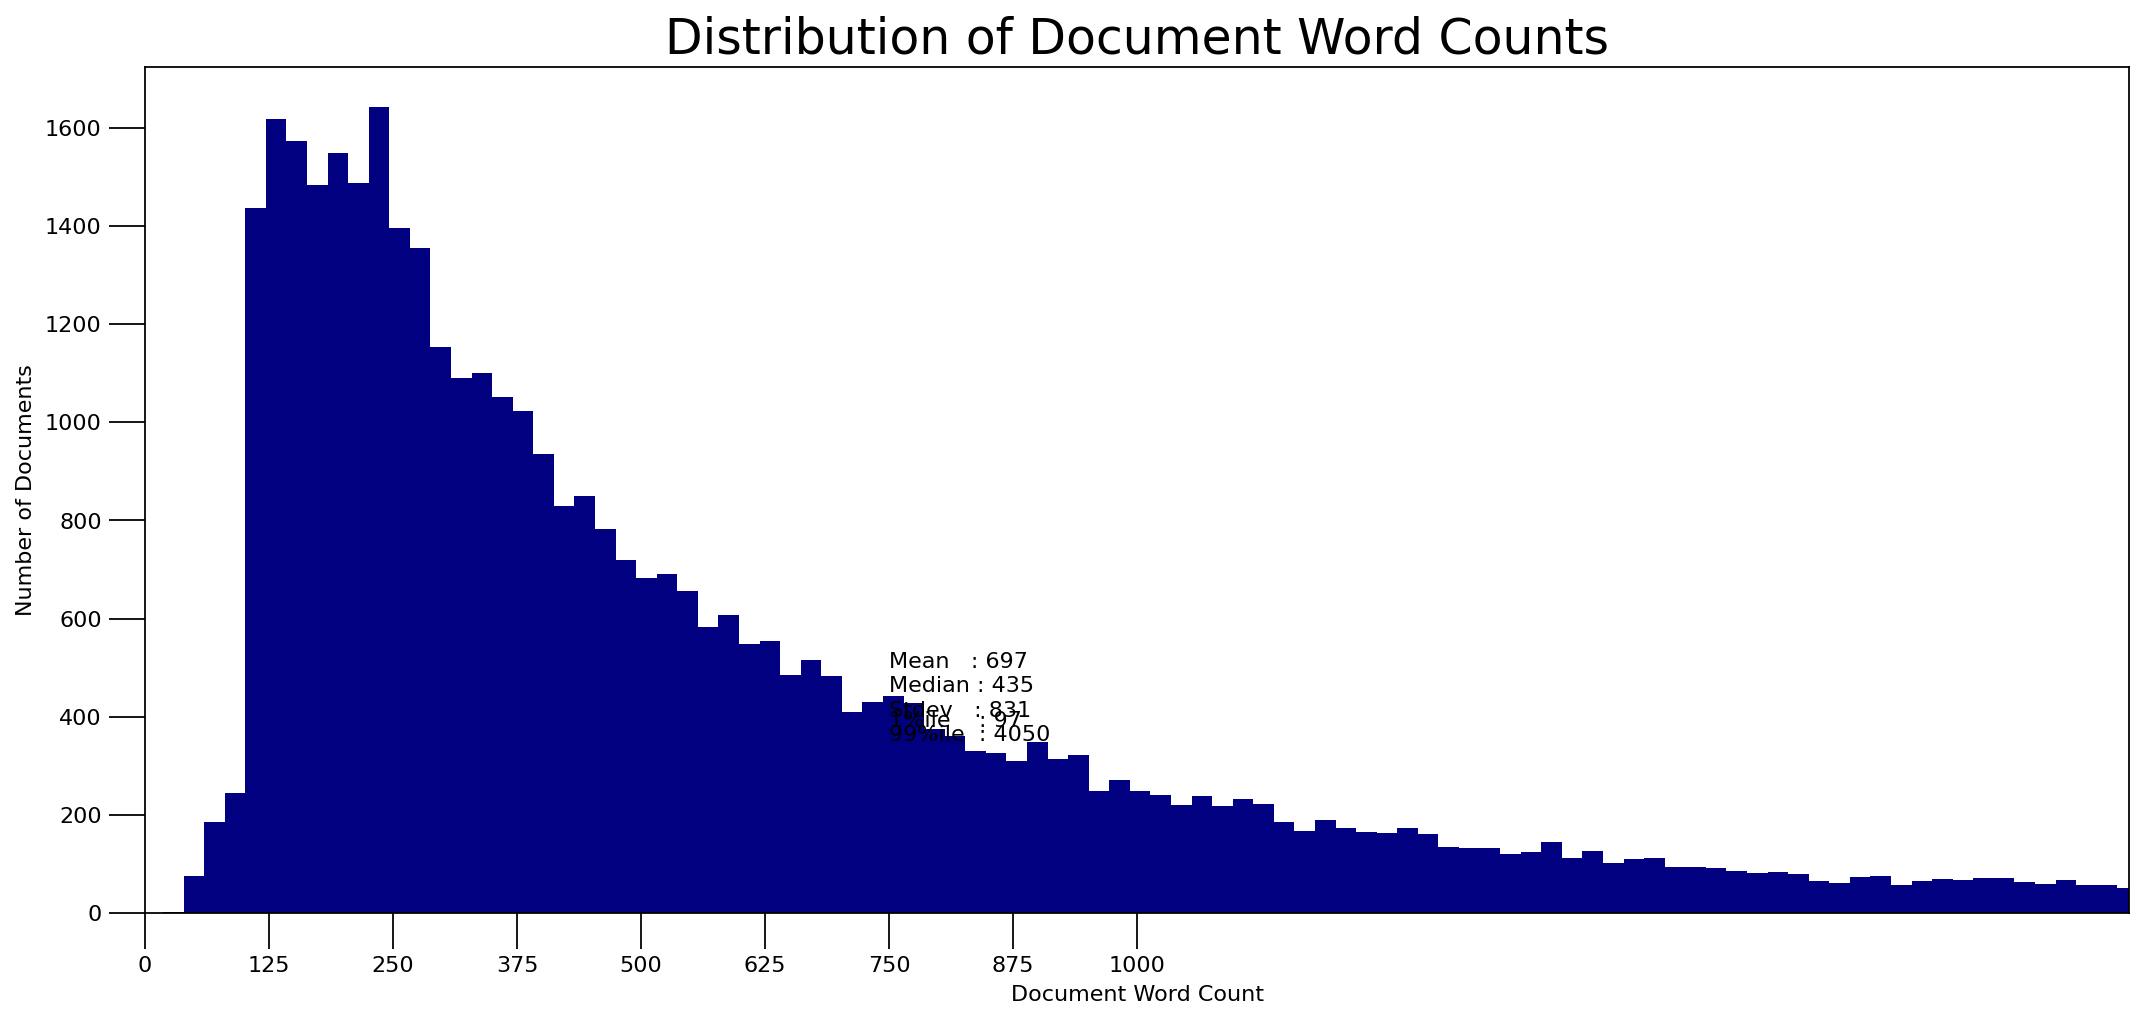

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 500, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  450, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  400, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  380, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  350, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 2000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


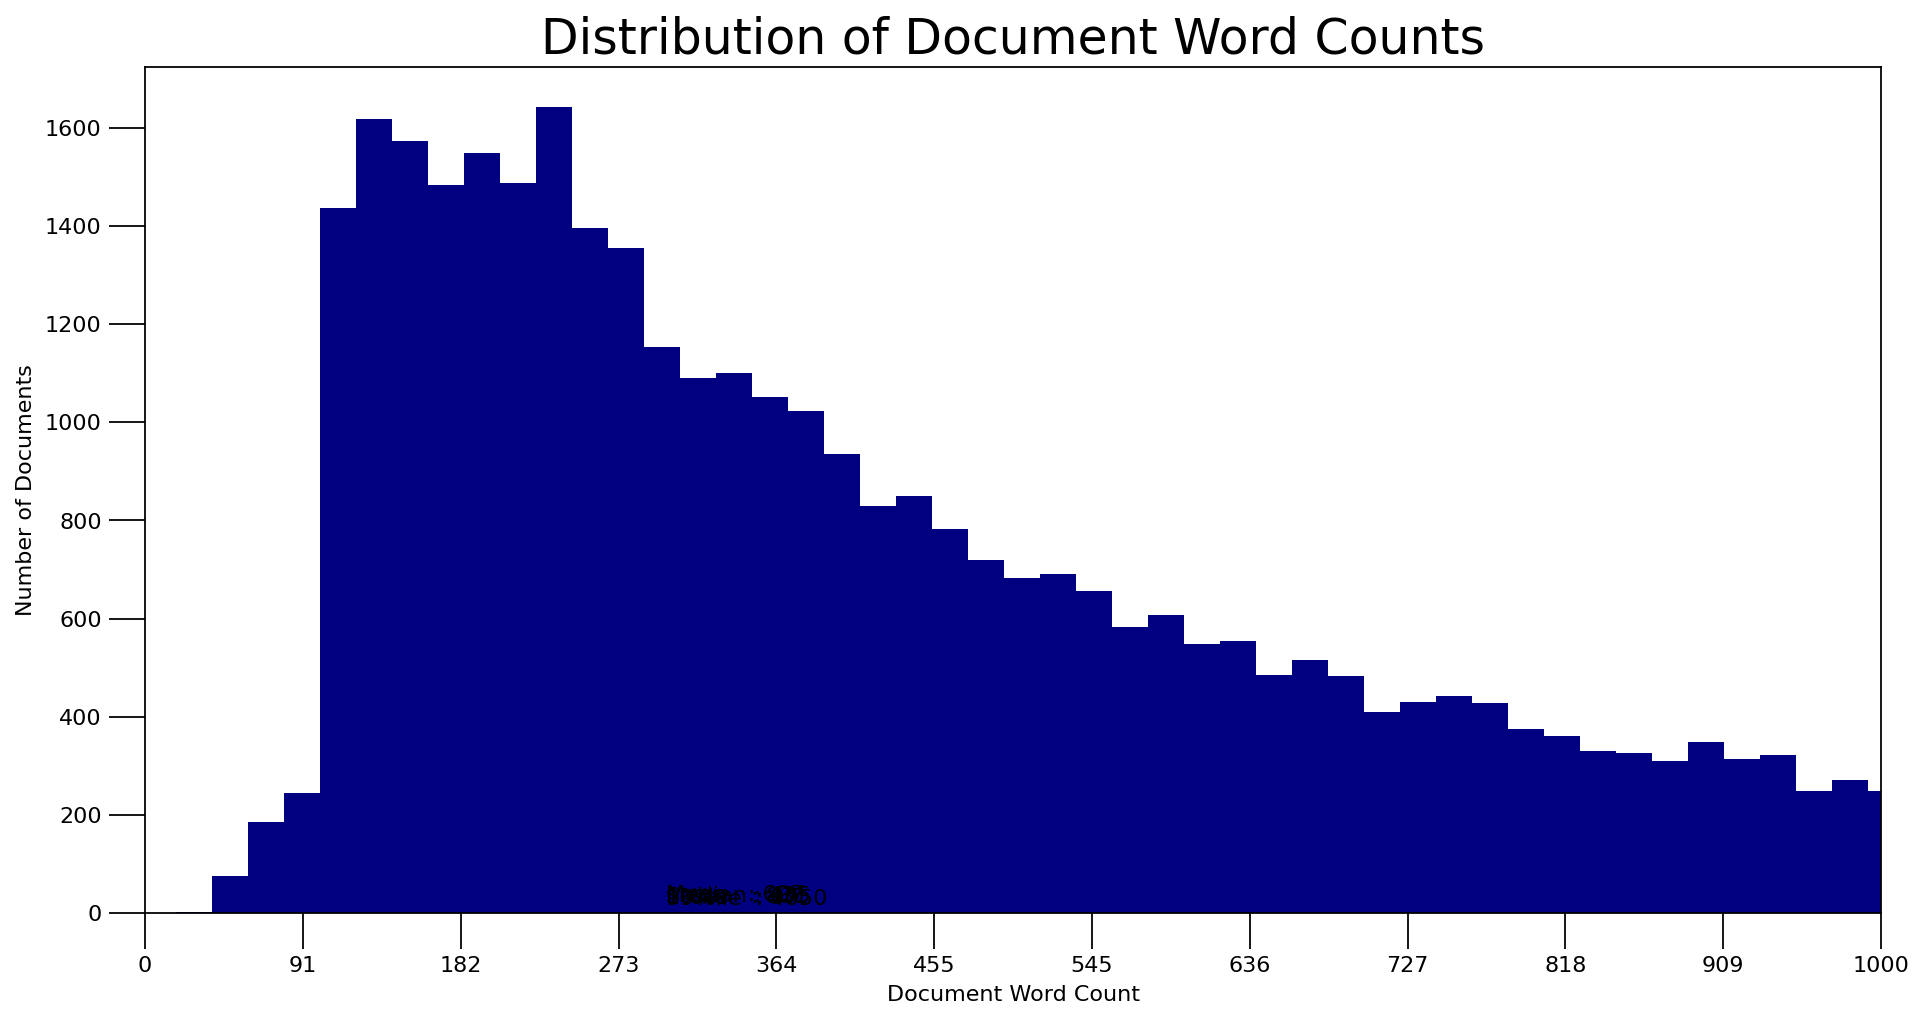

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(14,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(300, 25, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(300,  23, "Median : " + str(round(np.median(doc_lens))))
plt.text(300,  21, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(300,  19, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(300,  17, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 350), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,12))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

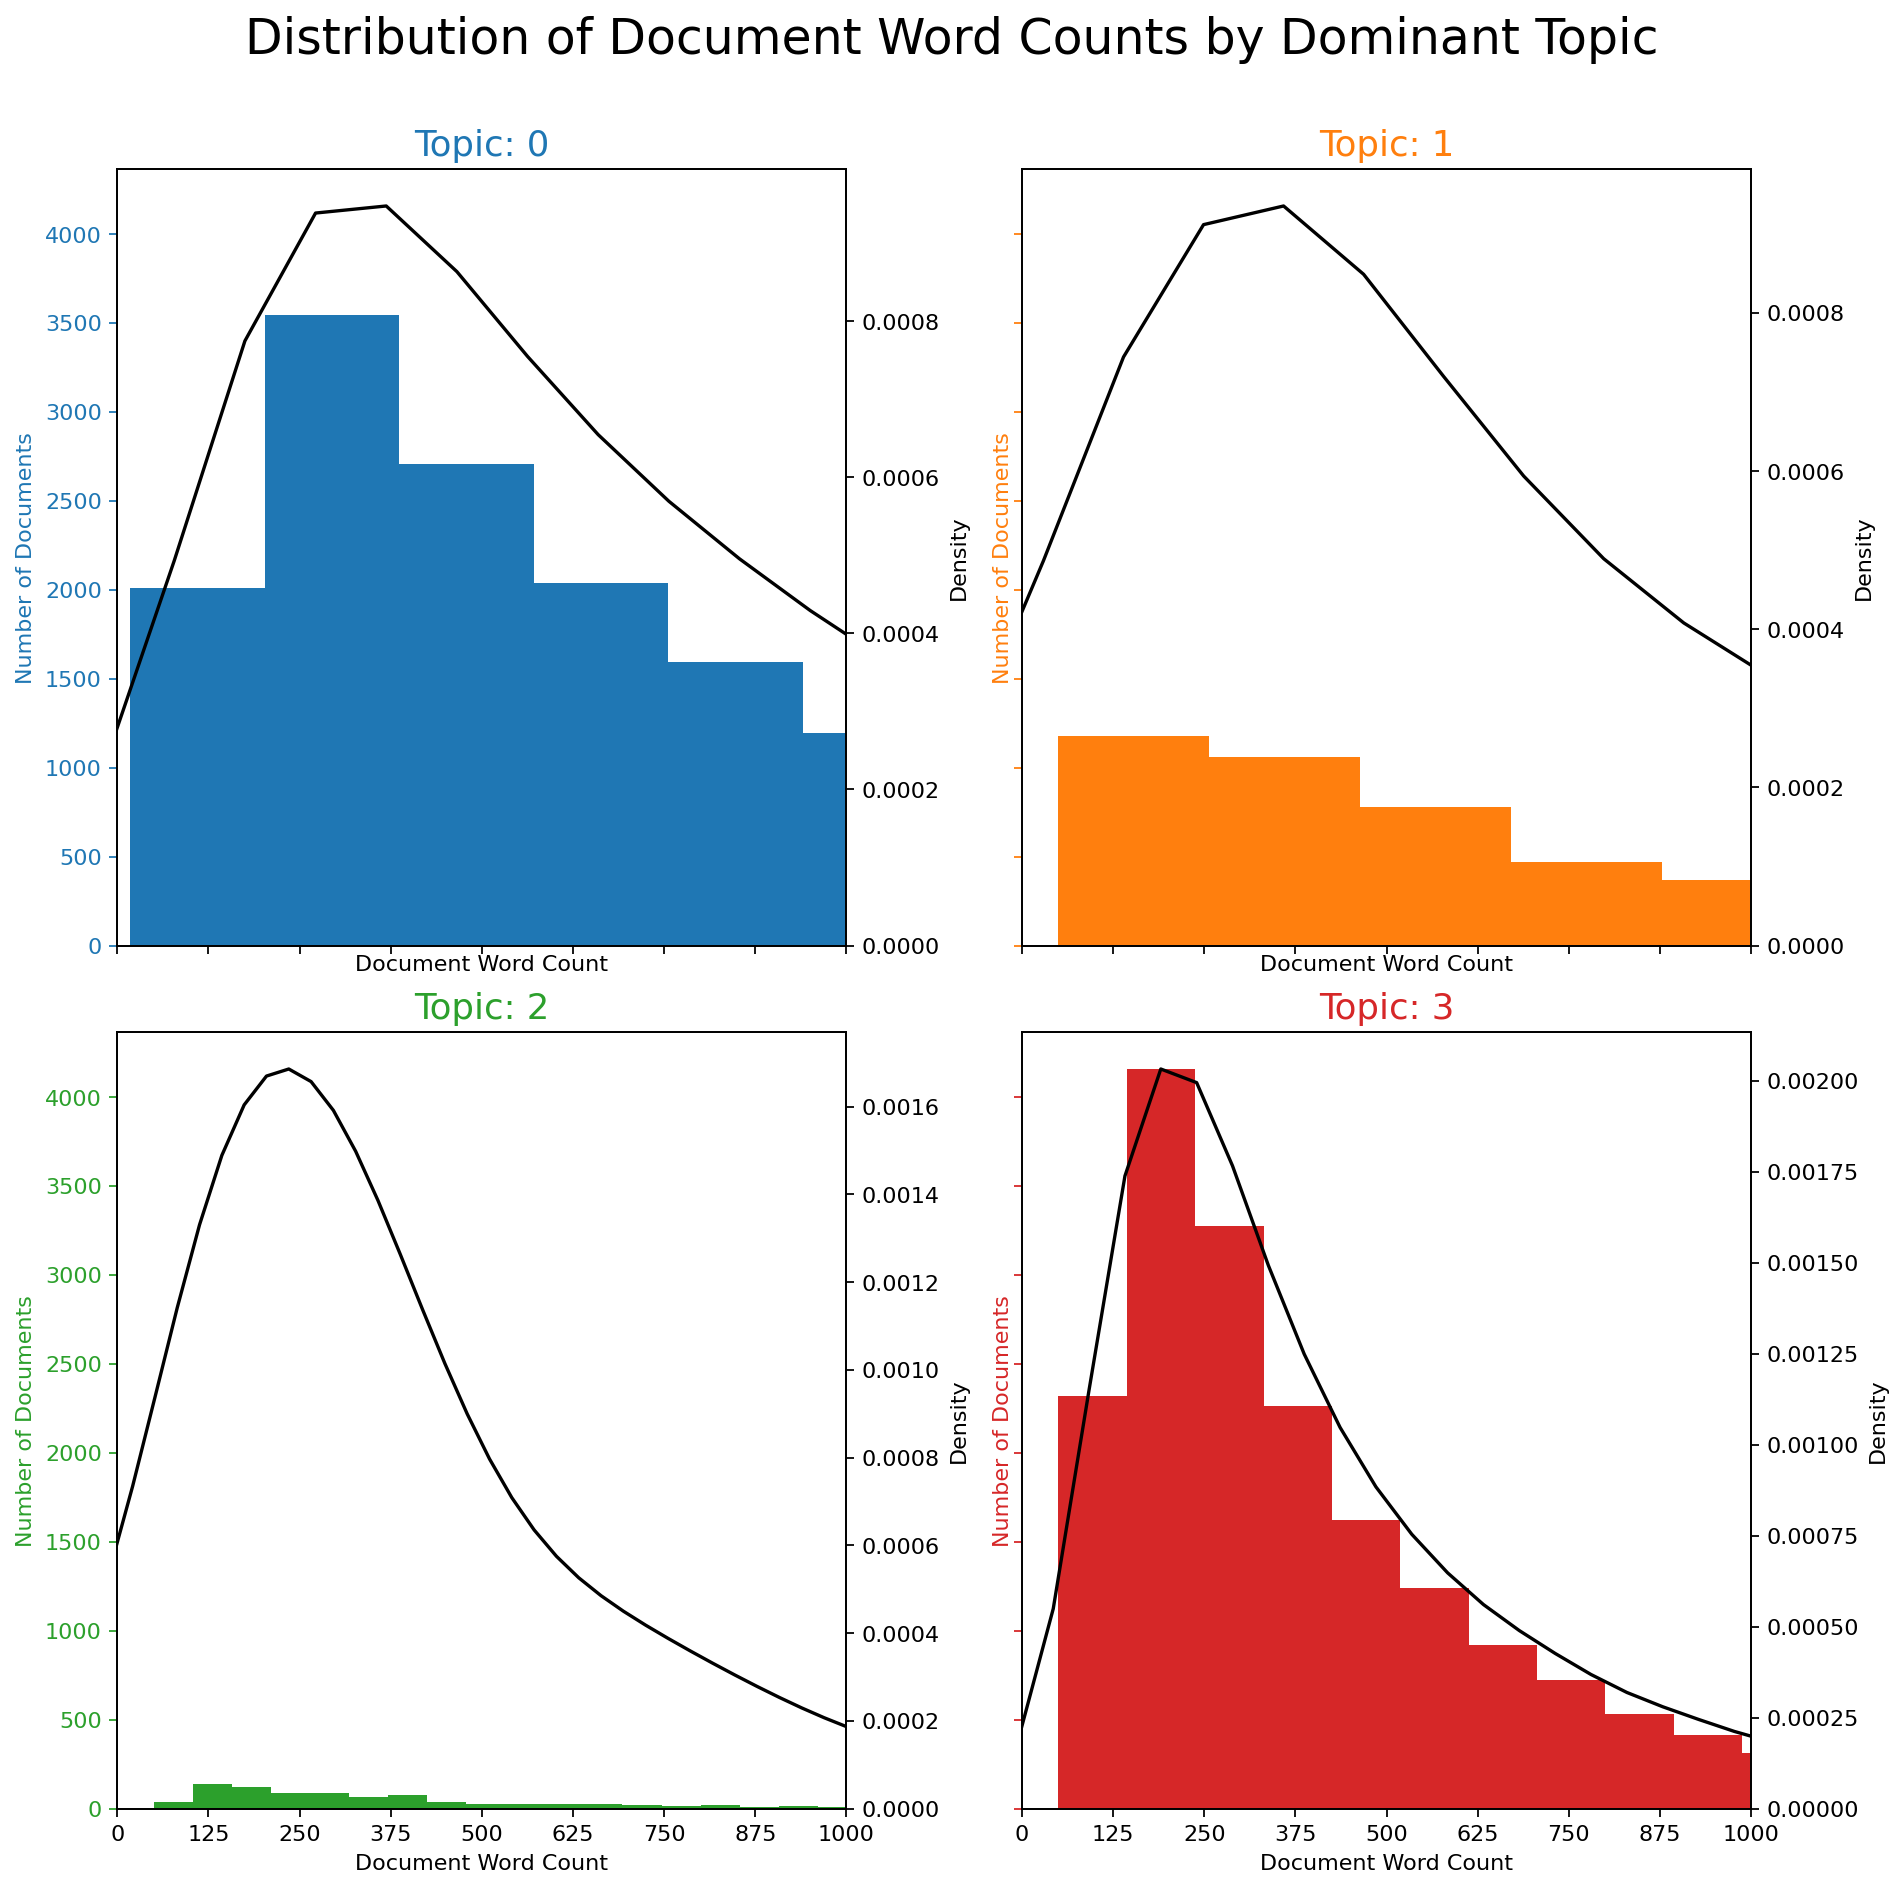

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(12,12), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show() 

In [ ]:
pip install wordcloud

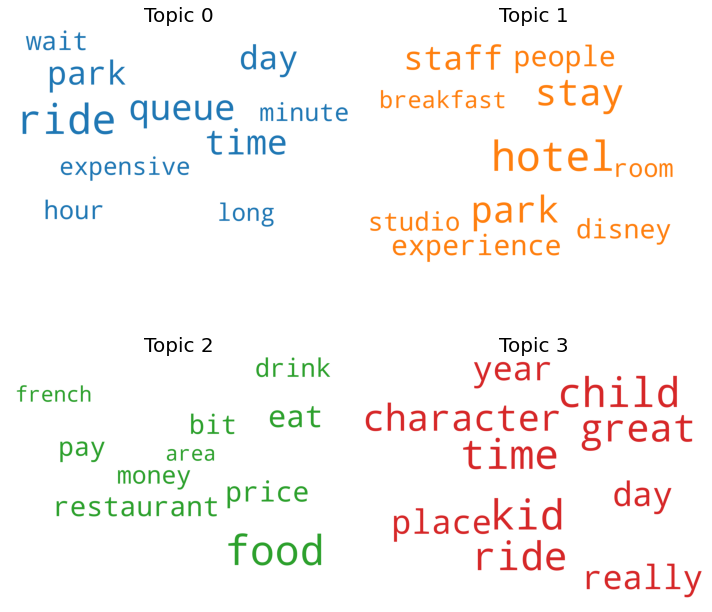

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

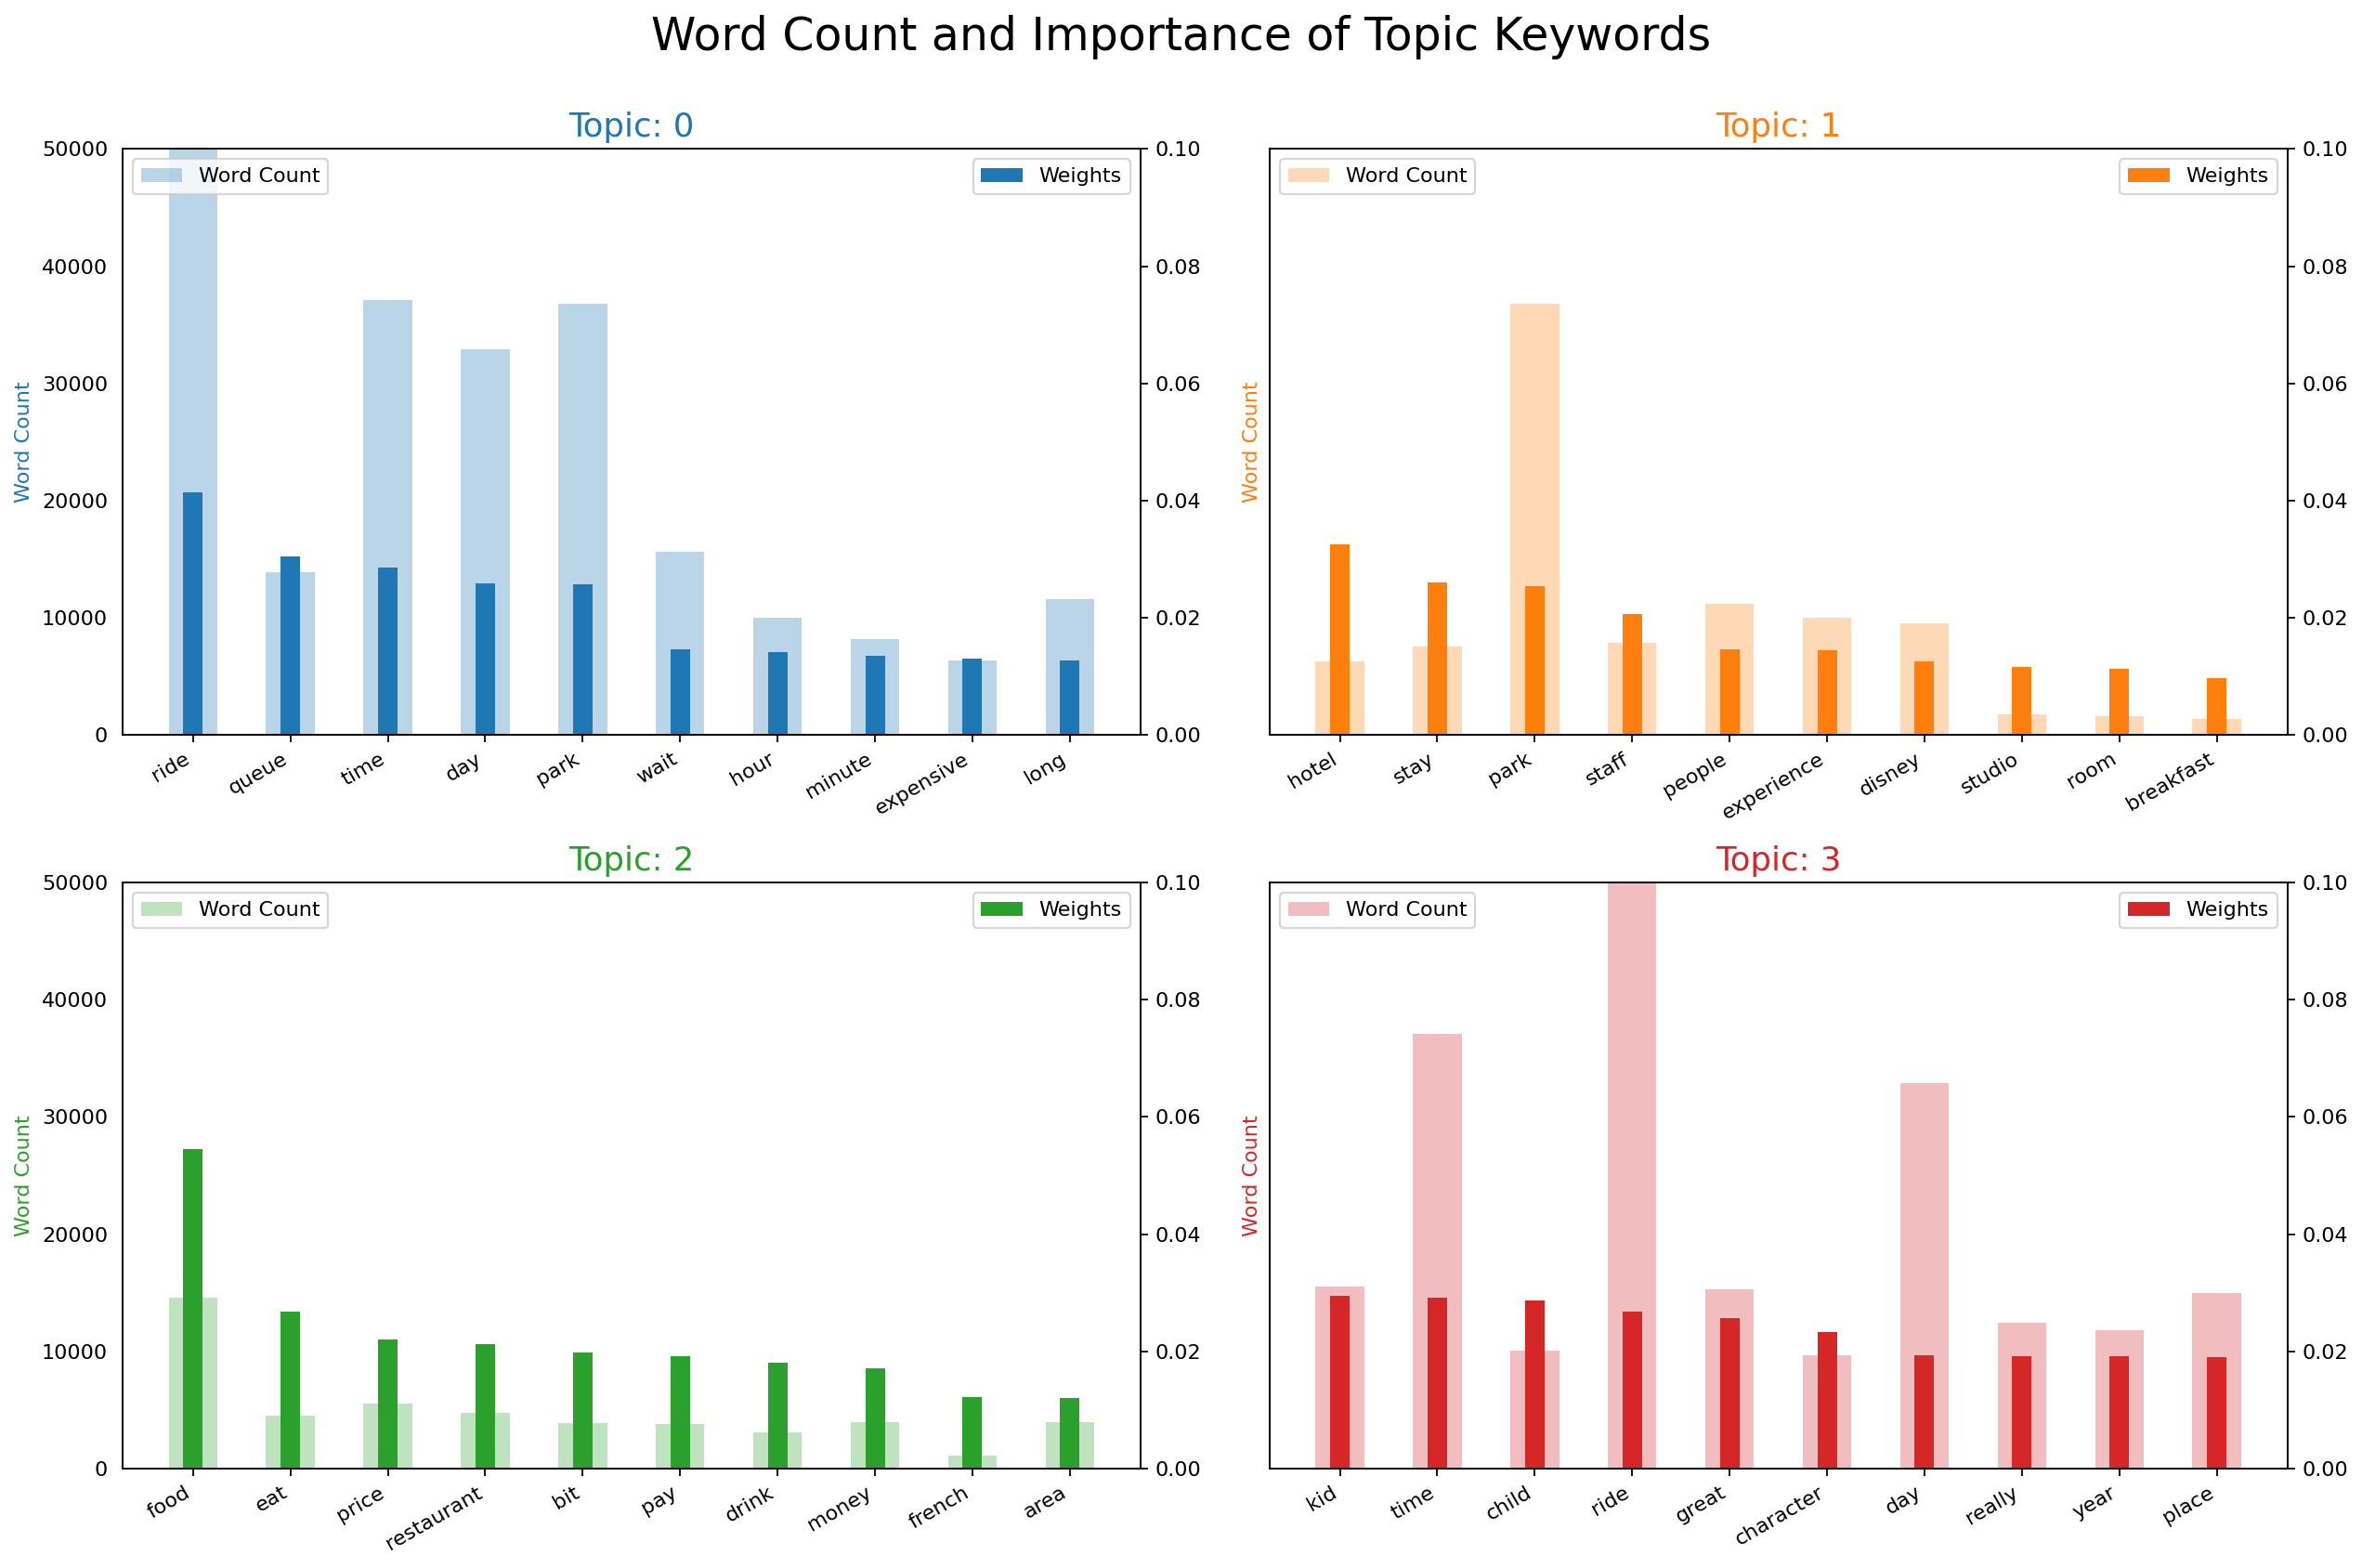

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.100); ax.set_ylim(0, 50000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show() 

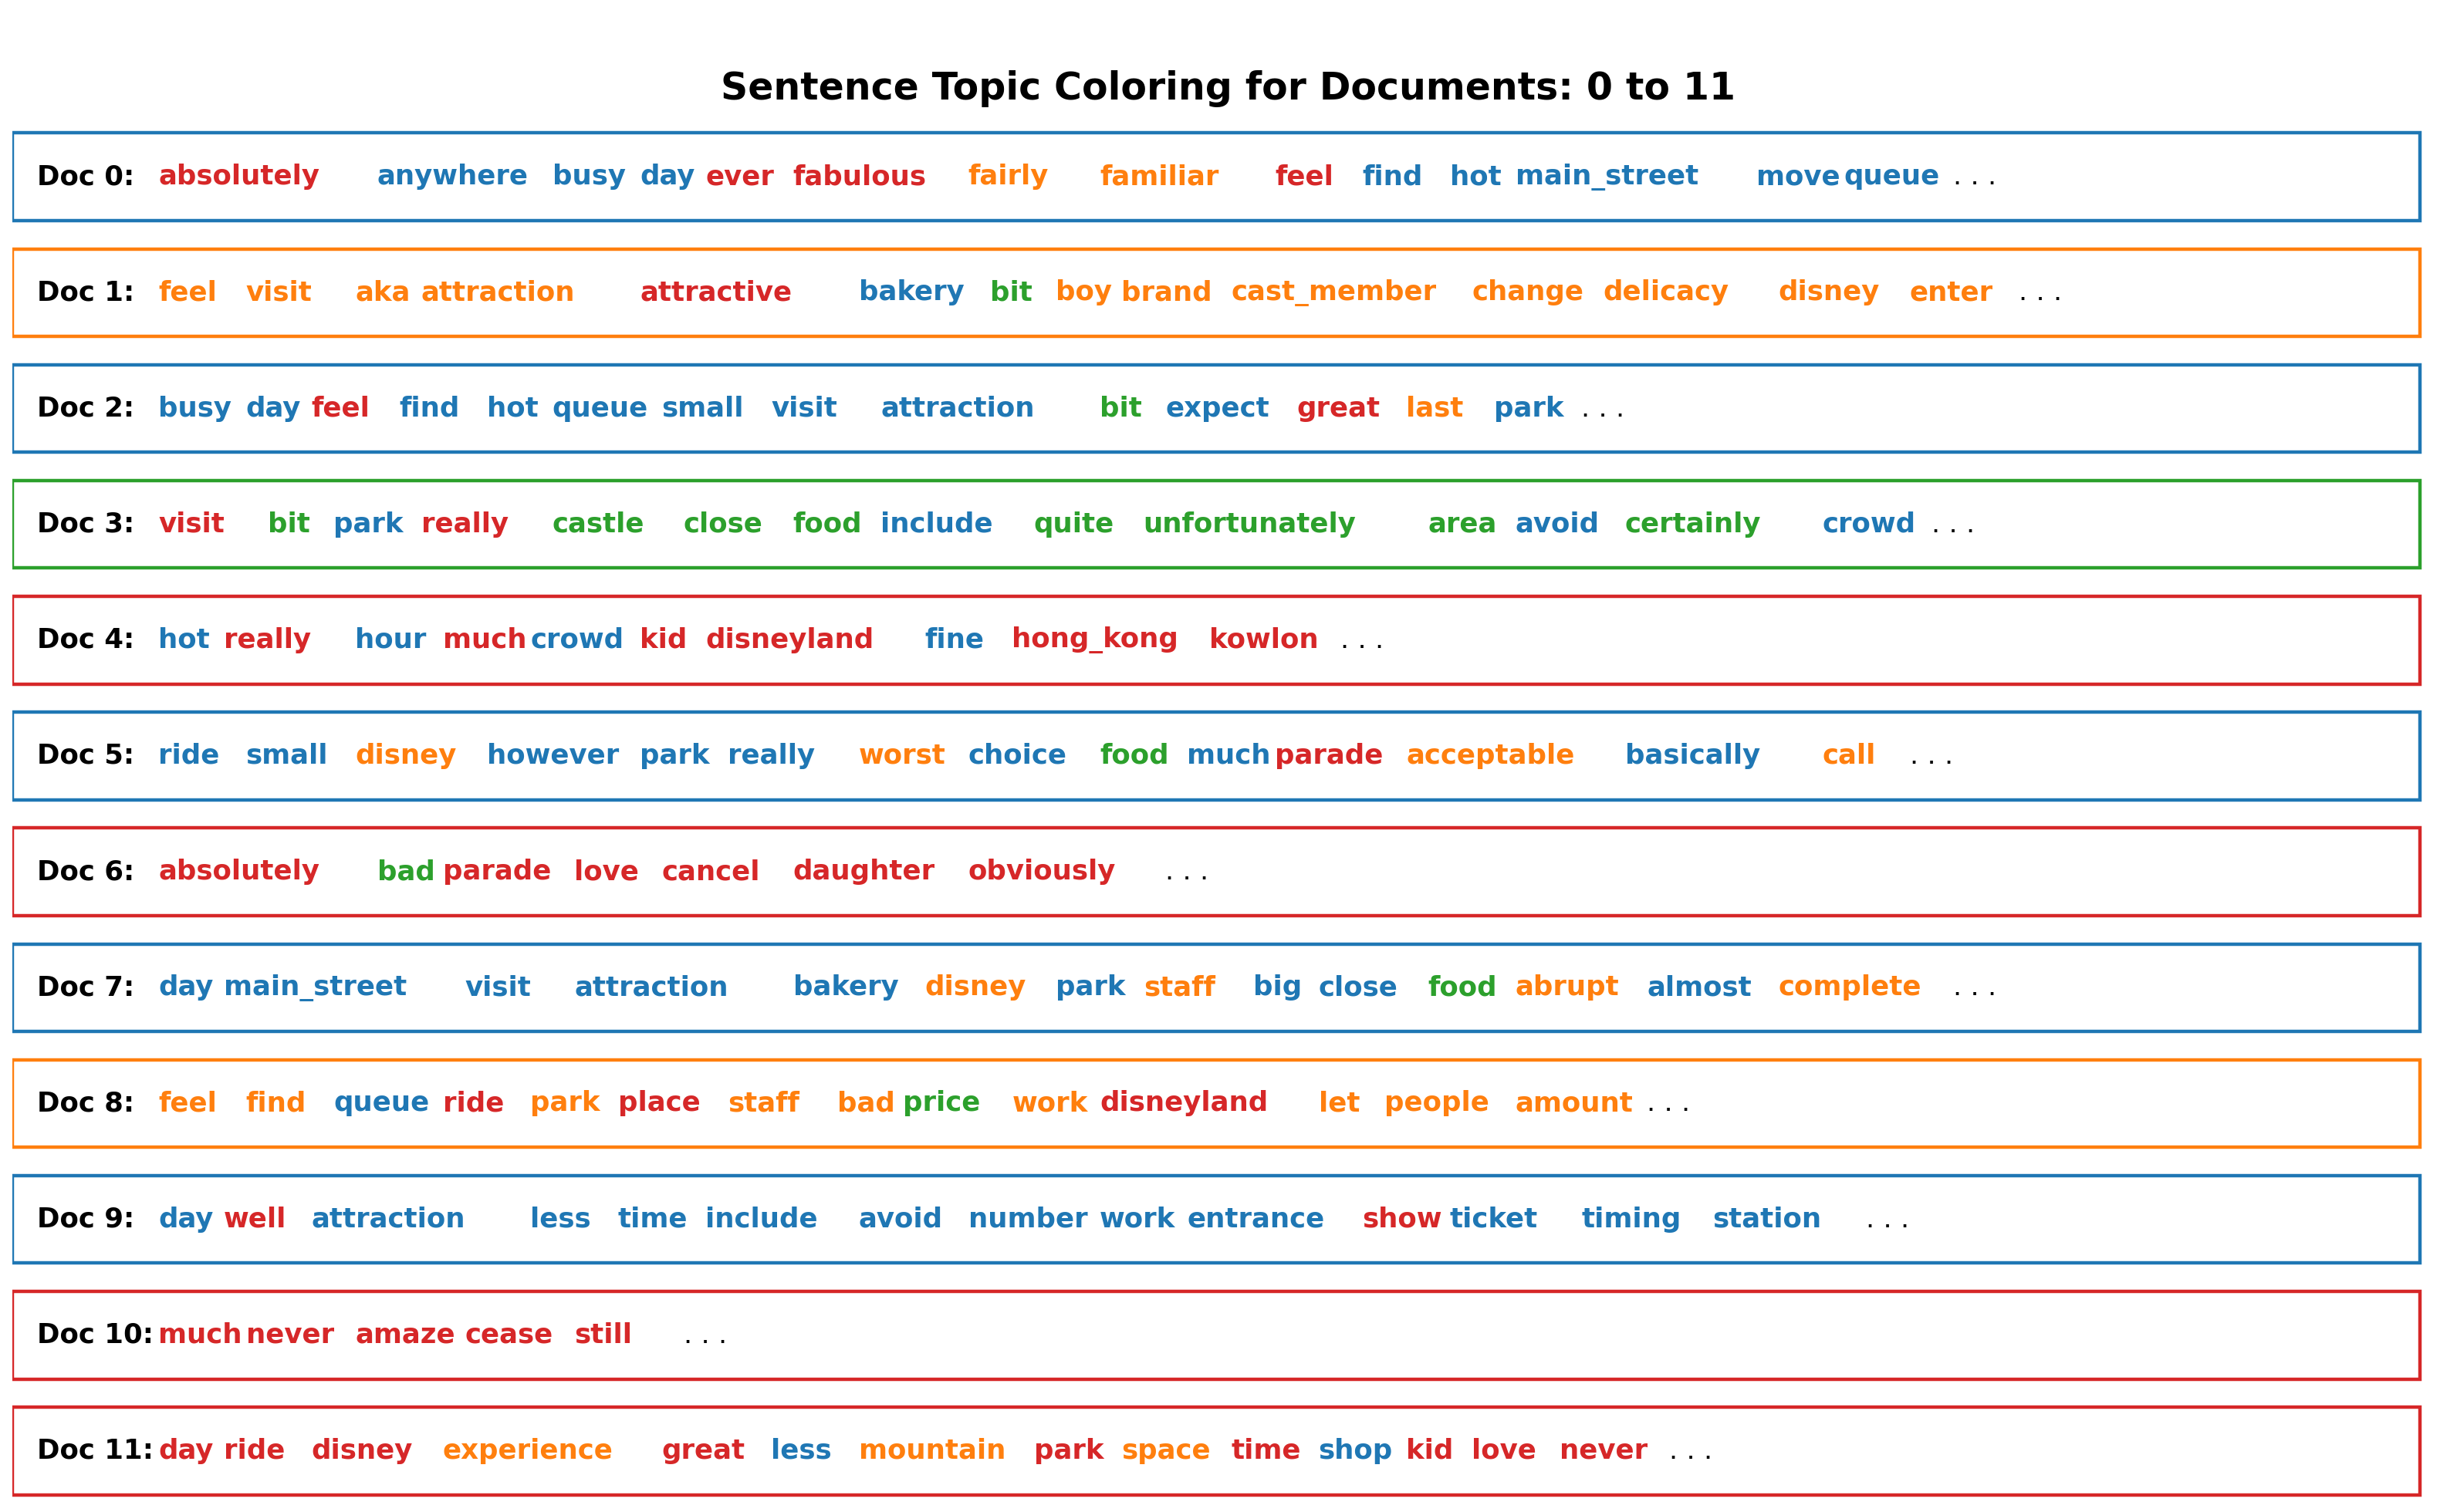

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


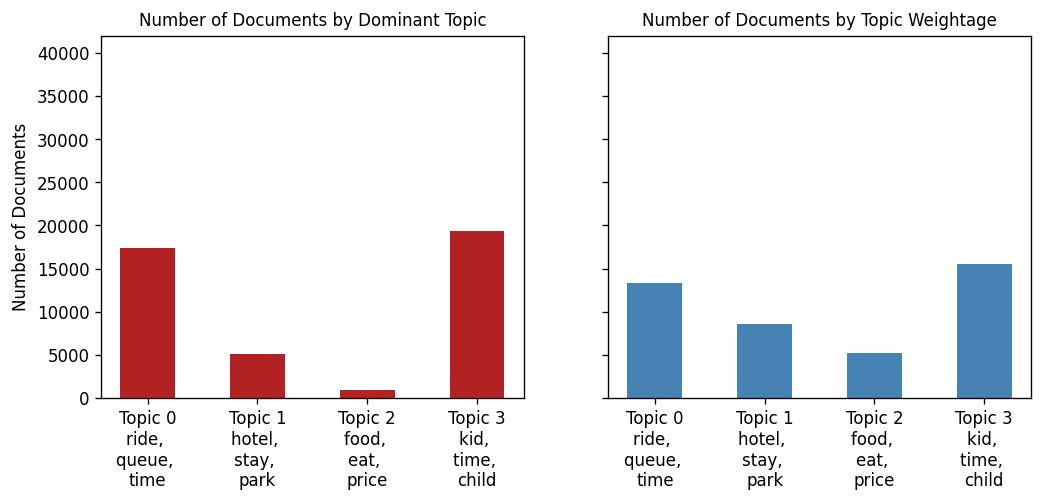

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 42000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=0.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

**T-SNE Clustering**

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=500, plot_height=500)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38718 samples in 0.029s...
[t-SNE] Computed neighbors for 38718 samples in 1.356s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38718
[t-SNE] Computed conditional probabilities for sample 2000 / 38718
[t-SNE] Computed conditional probabilities for sample 3000 / 38718
[t-SNE] Computed conditional probabilities for sample 4000 / 38718
[t-SNE] Computed conditional probabilities for sample 5000 / 38718
[t-SNE] Computed conditional probabilities for sample 6000 / 38718
[t-SNE] Computed conditional probabilities for sample 7000 / 38718
[t-SNE] Computed conditional probabilities for sample 8000 / 38718
[t-SNE] Computed conditional probabilities for sample 9000 / 38718
[t-SNE] Computed conditional probabilities for sample 10000 / 38718
[t-SNE] Computed conditional probabilities for sample 11000 / 38718
[t-SNE] Computed conditional probabilities for sample 12000 / 38718
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.116898
[t-SNE] KL divergence after 1000 iterations: 1.788393


In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 26.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=8dc96f4de3a646b4a2337bfe223019884520bc5c3eb3d2526d5720d2d4eabc0c
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompat

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.173183  0.105998       1        1  35.108637
3     -0.204086  0.125763       2        1  29.745133
1     -0.002041 -0.345961       3        1  22.287261
2      0.379310  0.114200       4        1  12.858969, topic_info=         Term          Freq         Total Category  logprob  loglift
85       food  13828.000000  13828.000000  Default  30.0000  30.0000
13      queue  19651.000000  19651.000000  Default  29.0000  29.0000
436     hotel  13366.000000  13366.000000  Default  28.0000  28.0000
116       kid  16122.000000  16122.000000  Default  27.0000  27.0000
138     child  15710.000000  15710.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
79      close   2362.265803   4307.579416   Topic4  -4.6075   1.4504
6598  village   2099.427761   3771.172589   Topic4  -4.7255   1.4654
8293    euros   1364.785522   1772.823609   Topic4  -5.1562   1.7896
37     expect   1514.973192   5526.025033   Topic4  -5.0518   0.7571
101     quite   1196.671945   3805.721942   Topic4  -5.2876   0.8942

[201 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.999919  absolutely
341       2  0.999902       adult
1437      4  0.999116      advice
270       2  0.999820         age
593       3  0.999907      always
...     ...       ...         ...
22        1  0.285865       worth
22        2  0.714184       worth
340       2  0.878065        year
340       3  0.121933        year
264       2  0.999889       young

[212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

NMF

In [ ]:
#the count vectorizer needs string inputs, not array, so I join them with a space.
train_review_sentences = [' '.join(text) for text in data_ready]

In [ ]:
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(train_review_sentences);

In [ ]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [ ]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
#obtain a NMF model.
model = NMF(n_components=n_topics, init='nndsvd');

In [ ]:
#fit the model
model.fit(xtfidf_norm)

NMF(init='nndsvd', n_components=4)

In [ ]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(n_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [ ]:
get_nmf_topics(model, 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic # 01 Topic # 02  Topic # 03 Topic # 04
0       ride      place        love      great
1        day        kid      always       time
2       park      happy        year     always
3       time      earth        back        fun
4      visit      visit         old     family
5       wait     family         kid       food
6       long      enjoy  absolutely      crowd
7       pass    magical     amazing        age
8      small      adult  disneyland       ride
9      queue       must        much        day

**LSA**

In [ ]:
pip install textblob

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
nltk.download('stopwords')


%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
reviews = pd.read_csv('DisneylandReviews.csv',  encoding= 'unicode_escape')
reviews.head()

Review_ID  ...               Branch
0  670772142  ...  Disneyland_HongKong
1  670682799  ...  Disneyland_HongKong
2  670623270  ...  Disneyland_HongKong
3  670607911  ...  Disneyland_HongKong
4  670607296  ...  Disneyland_HongKong

[5 rows x 6 columns]

In [ ]:
reviewed_data = reviews['Review_Text']
reviewed_data.head()

0    If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the ...
1    Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomo...
2    Thanks God it wasn   t too hot or too humid when I was visiting the park   otherwise it would be...
3    HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work go...
4    the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much...
Name: Review_Text, dtype: object

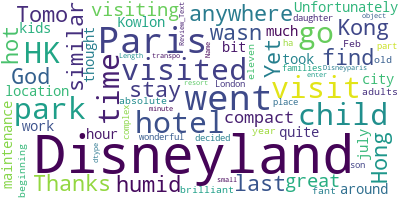

In [ ]:
#Import the wordcloud library
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(str(reviews['Review_Text']))
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_reviews = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_reviews, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_reviews.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

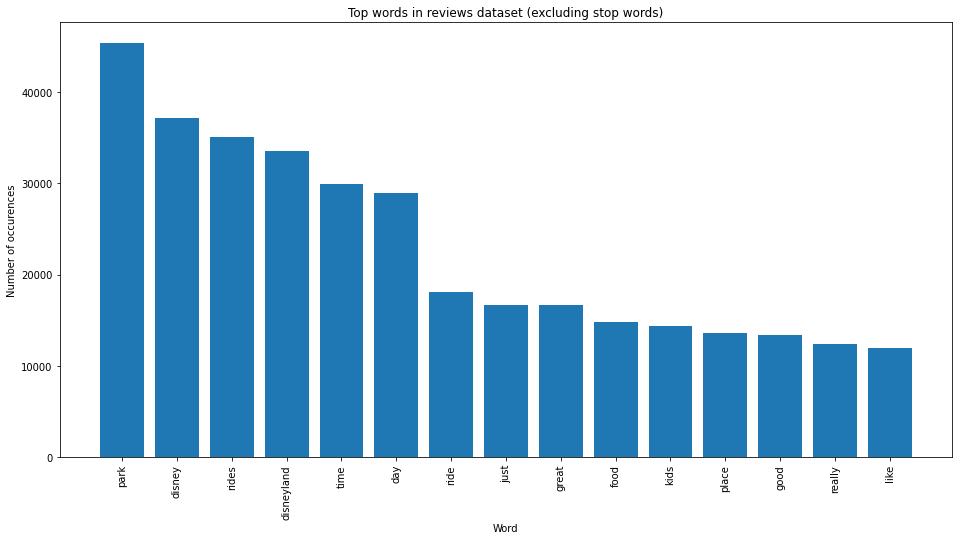

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reviewed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in reviews dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [ ]:
tagged_reviews = [TextBlob(reviewed_data[i]).pos_tags for i in range(reviewed_data.shape[0])]

In [ ]:
tagged_reviews_df = pd.DataFrame({'tags':tagged_reviews})

word_counts = [] 
pos_counts = {}

for review in tagged_reviews_df[u'tags']:
    word_counts.append(len(review))
    for tag in review:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per reviews: ', np.mean(word_counts))

Total number of words:  5603254
Mean number of words per reviews:  131.35910540135035


In [ ]:
'''
y = stats.norm.pdf(np.linspace(0,25,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,25), density=True);
ax.plot(np.linspace(0,25,50), y, 'r--', linewidth=1);
ax.set_title('Reviews word lengths');
ax.set_xticks(range(1,25));
ax.set_xlabel('Number of words');
plt.show()
'''

"\ny = stats.norm.pdf(np.linspace(0,25,50), np.mean(word_counts), np.std(word_counts))\n\nfig, ax = plt.subplots(figsize=(18,8))\nax.hist(word_counts, bins=range(1,25), density=True);\nax.plot(np.linspace(0,25,50), y, 'r--', linewidth=1);\nax.set_title('Reviews word lengths');\nax.set_xticks(range(1,25));\nax.set_xlabel('Number of words');\nplt.show()\n"

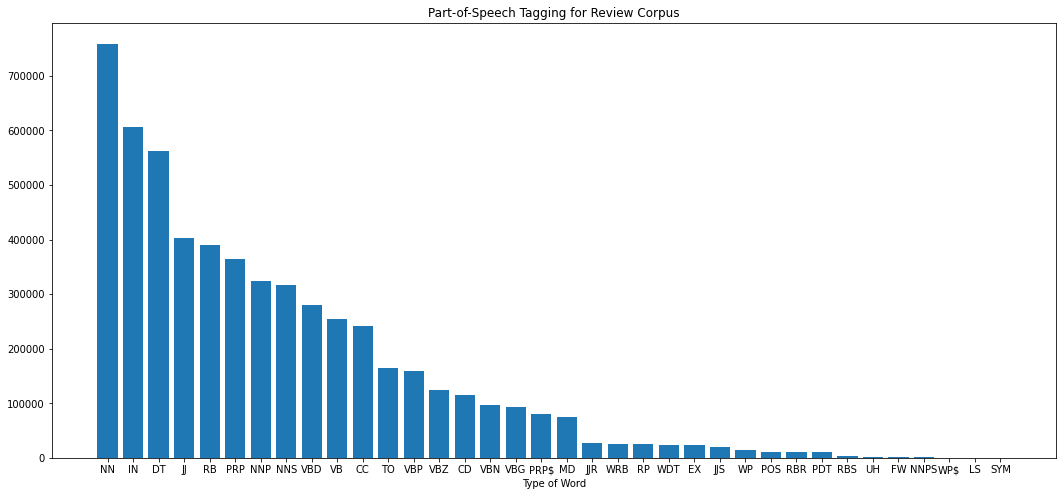

In [ ]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Review Corpus');
ax.set_xlabel('Type of Word');

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reviewed_data.sample(n=1000, random_state=0).values

print('Review before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Review after vectorization: \n{}'.format(small_document_term_matrix[123]))

Review before vectorization: The park was crowded. There are no clocks anywhere. No princesses or other characters unless you paid big bucks to go to a breakfast. Bibbity salon is crazy expensive. It was fun but can't say it was happy. Too many reserved seats and nothing for the poor joes. Staff complaining all the time and there were some very rude ones. 
Review after vectorization: 
  (0, 4610)	1
  (0, 6510)	1
  (0, 1239)	1
  (0, 3066)	1
  (0, 848)	1
  (0, 5563)	1
  (0, 6033)	1
  (0, 4446)	1
  (0, 4958)	1
  (0, 2808)	1
  (0, 2443)	1
  (0, 1715)	1
  (0, 5490)	1
  (0, 1684)	1
  (0, 967)	1
  (0, 6773)	1
  (0, 4863)	1
  (0, 5359)	1
  (0, 5625)	1
  (0, 4571)	1
  (0, 1010)	1
  (0, 1492)	1
  (0, 1376)	1
  (0, 846)	1
  (0, 5526)	1
  (0, 3547)	1


In [ ]:
n_topics = 4

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [ ]:
#Topics for document 0:
for i, topic in enumerate(lsa_topic_matrix[0]):
    print("Topic ", i, " : ", topic*100)

Topic  0  :  205.12281343652012
Topic  1  :  -11.149994676952112
Topic  2  :  57.9912127692416
Topic  3  :  13.228028825534146


In [ ]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(4, 7223)
[[ 7.63117297e-03  4.59421758e-03  2.00752082e-04 ...  3.89763072e-03
   1.80740471e-03  7.73960799e-04]
 [-1.74343916e-02 -1.29755501e-02 -3.41047755e-04 ... -5.52912175e-03
  -2.59486972e-03 -4.70344624e-03]
 [ 7.43007223e-04  6.17799359e-04  8.55703015e-05 ...  3.09474920e-03
   2.86653668e-03  7.19001692e-04]
 [ 3.15681289e-03  1.01795052e-02  3.06827842e-04 ... -2.10215801e-03
   2.09926301e-03  3.16431657e-03]]


In [ ]:
#Now we can get a list of the important words for each of the 5 topics as shown. 
#For simplicity here I have shown 5 words for each topic.
vocab = small_count_vectorizer.get_feature_names_out()
topic_content = []
for v in lsa_model.components_:
    sorted_vocab = sorted(zip(vocab, v), key=lambda x : x[1], reverse=True)
    topic_content.append({x:y for x, y in sorted_vocab})

In [ ]:
print("Top 5 words in topic 1 : ", list(topic_content[0].keys())[:5])
print("Top 5 words in topic 2 : ", list(topic_content[1].keys())[:5])
print("Top 5 words in topic 3 : ", list(topic_content[2].keys())[:5])
print("Top 5 words in topic 4 : ", list(topic_content[3].keys())[:5])


Top 5 words in topic 1 :  ['park', 'disney', 'disneyland', 'rides', 'day']
Top 5 words in topic 2 :  ['disney', 'paris', 'hotel', 'staff', 'room']
Top 5 words in topic 3 :  ['time', 'disneyland', 'birthday', 'son', 'went']
Top 5 words in topic 4 :  ['disney', 'time', 'ride', 'mountain', 'rides']


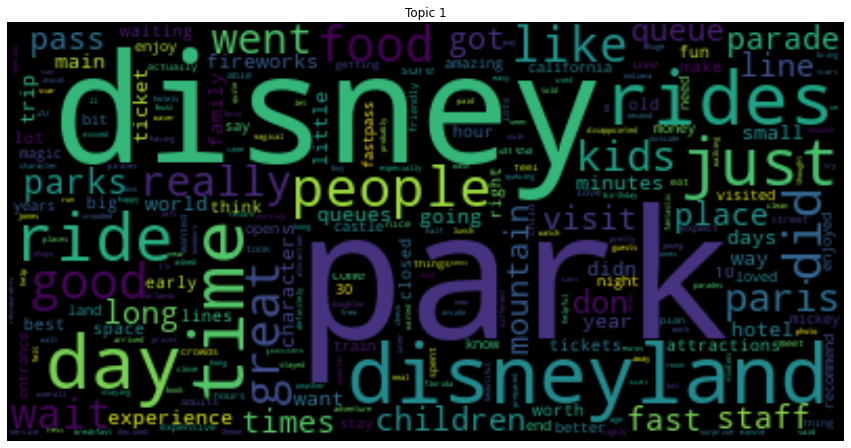

In [ ]:
wc1= WordCloud(background_color="black", max_words=500)
wc1.generate_from_frequencies(topic_content[0])

fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wc1, interpolation="bilinear")
plt.title("Topic 1")
plt.axis("off")
plt.show()

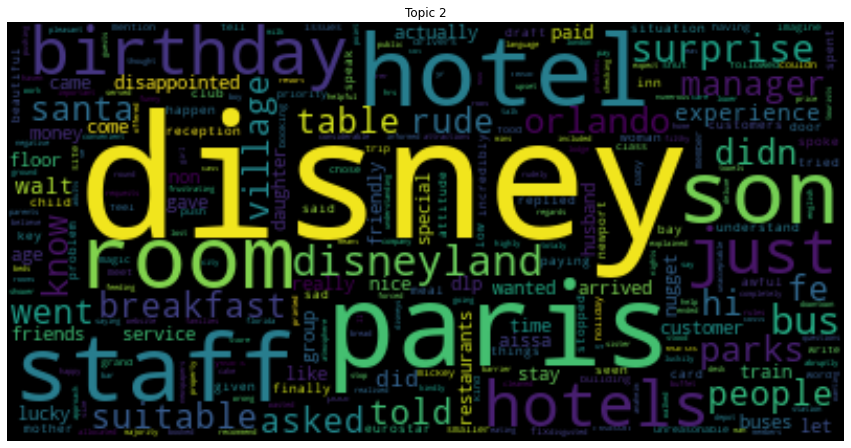

In [ ]:
wc2= WordCloud(background_color="black", max_words=500)
wc2.generate_from_frequencies(topic_content[1])

fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wc2, interpolation="bilinear")
plt.title("Topic 2")
plt.axis("off")
plt.show()

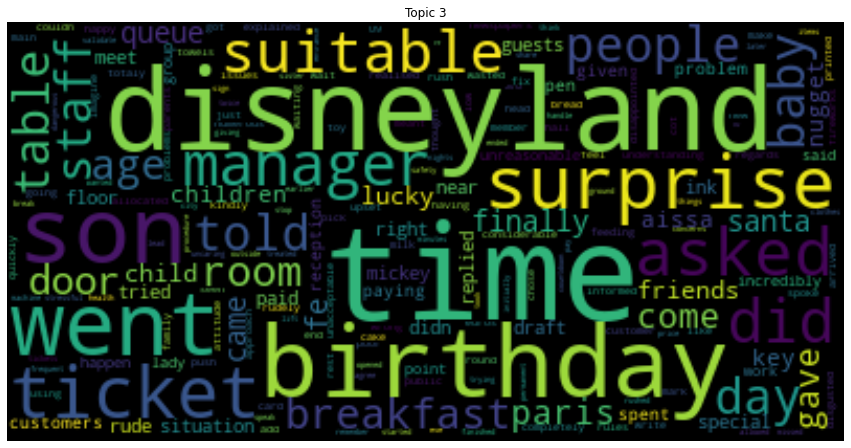

In [ ]:
wc3= WordCloud(background_color="black", max_words=500)
wc3.generate_from_frequencies(topic_content[2])

fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wc3, interpolation="bilinear")
plt.title("Topic 3")
plt.axis("off")
plt.show()

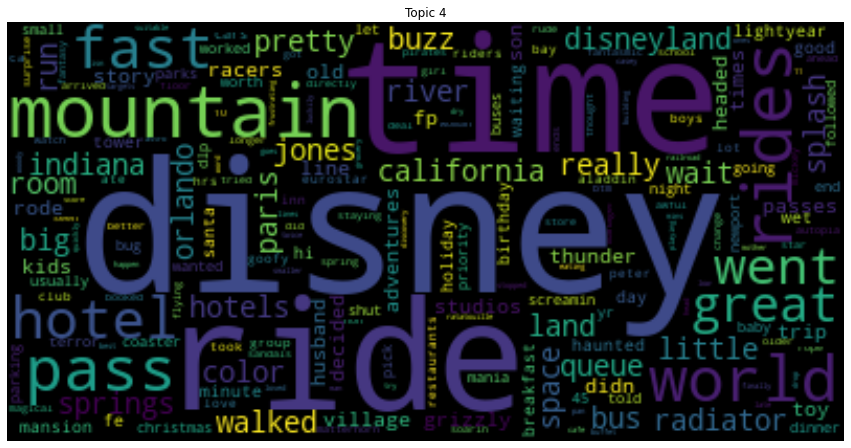

In [ ]:
wc4= WordCloud(background_color="black", max_words=500)
wc4.generate_from_frequencies(topic_content[3])

fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wc4, interpolation="bilinear")
plt.title("Topic 4")
plt.axis("off")
plt.show()

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.397737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.847473
[t-SNE] KL divergence after 2000 iterations: 0.694810


In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
n_topics=4
plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=500, plot_height=500)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=mycolors[lsa_keys])
    
show(plot)

**GSDMM**

In [ ]:
pip install git+https://github.com/rwalk/gsdmm.git

  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-_dko_lnz
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-_dko_lnz
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4603 sha256=7989a55460de337af77813864f1d841051aa3063748bb25c95033fd4c4478612
  Stored in directory: /tmp/pip-ephem-wheel-cache-n9grcgyb/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm


In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import gensim
from gsdmm import MovieGroupProcess

# cast tweets to numpy array
#docs = df['Review_Text'].to_numpy()

# create dictionary of all words in all documents
dictionary = gensim.corpora.Dictionary(data_ready)

# filter extreme cases out of dictionary
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# create variable containing length of dictionary/vocab
vocab_length = len(dictionary)

# create BOW dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in data_ready]

# initialize GSDMM
gsdmm = MovieGroupProcess(K=4, alpha=0.1, beta=0.3, n_iters=15)

# fit GSDMM model
y = gsdmm.fit(data_ready, vocab_length)

In stage 0: transferred 31076 clusters with 4 clusters populated
In stage 1: transferred 23554 clusters with 4 clusters populated
In stage 2: transferred 14090 clusters with 4 clusters populated
In stage 3: transferred 9690 clusters with 4 clusters populated
In stage 4: transferred 8605 clusters with 4 clusters populated
In stage 5: transferred 8166 clusters with 4 clusters populated
In stage 6: transferred 7975 clusters with 4 clusters populated
In stage 7: transferred 7795 clusters with 4 clusters populated
In stage 8: transferred 7681 clusters with 4 clusters populated
In stage 9: transferred 7372 clusters with 4 clusters populated
In stage 10: transferred 7424 clusters with 4 clusters populated
In stage 11: transferred 7331 clusters with 4 clusters populated
In stage 12: transferred 7180 clusters with 4 clusters populated
In stage 13: transferred 7181 clusters with 4 clusters populated
In stage 14: transferred 7249 clusters with 4 clusters populated


In [ ]:
# print number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topics
top_words(gsdmm.cluster_word_distribution, top_index, 20)

Number of documents per topic : [ 7438 15489 10960  8769]
Most important clusters (by number of docs inside): [1 2 3 0]

Cluster 1 : [('ride', 10049), ('time', 7551), ('park', 7105), ('day', 6403), ('place', 5971), ('visit', 5776), ('great', 5121), ('kid', 5071), ('love', 5043), ('year', 3495), ('show', 3470), ('enjoy', 3440), ('fun', 3242), ('small', 3223), ('experience', 3149), ('much', 3109), ('really', 3073), ('parade', 2864), ('disneyland', 2756), ('family', 2706)]

Cluster 2 : [('ride', 14097), ('time', 10244), ('day', 9961), ('park', 8279), ('pass', 5723), ('wait', 5438), ('fast', 4282), ('visit', 4137), ('long', 3670), ('great', 3649), ('kid', 3112), ('crowd', 3089), ('ticket', 2975), ('show', 2821), ('food', 2758), ('place', 2652), ('hour', 2618), ('early', 2497), ('much', 2363), ('enjoy', 2362)]

Cluster 3 : [('ride', 19733), ('park', 15446), ('time', 13949), ('day', 11885), ('queue', 6481), ('people', 6383), ('wait', 6280), ('food', 5373), ('visit', 5309), ('pass', 5224), ('

In [ ]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4'
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [ ]:
def create_topics_dataframe(data_text=reviews['Review_Text'],  mgp=gsdmm, threshold=0.3, topic_dict=topic_dict, lemma_text=data_ready):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(data_ready[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [ ]:
result = create_topics_dataframe(data_text=reviews.Review_Text, mgp=gsdmm, threshold=0.3, topic_dict=topic_dict, lemma_text=data_ready)
result.head(10)

Text  ...                                                                                           Lemma-text
0  If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the ...  ...  [ever, anywhere, find, similar, walk, main_street, familiar, feel, ride, small, world, absolutel...
1  Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomo...  ...  [last, time, visit, time, stay, aka, marvel, land, experience, newly, open, great, feature, exci...
2  Thanks God it wasn   t too hot or too humid when I was visiting the park   otherwise it would be...  ...  [hot, visit, park, otherwise, big, issue, shade, arrive, around, left, pm, unfortunately, last, ...
3  HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work go...  ...  [park, unfortunately, quite, bit, maintenance, work, present, number, area, close, include, famo...
4  the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much...  ...                           [hour, kowlon, kid, disneyland, much, fine, really, crowd, hot, hong_kong]
5  Have been to Disney World, Disneyland Anaheim and Tokyo Disneyland but I feel that Disneyland Ho...  ...  [really, small, call, souvenir, food, entrance, ticket, slightly, expensive, basically, park, sm...
6  Great place! Your day will go by and you won't even know it. Obviously went there for my daughte...  ...                                         [obviously, daughter, absolutely, love, bad, parade, cancel]
7  Think of it as an intro to Disney magic for the little ones. Almost all of the attractions can b...  ...  [little, one, almost, attraction, complete, day, drawback, timing, example, disney, close, thu, ...
8  Feel so let down with this place,the Disneyland train was fantastic until you get past the stati...  ...  [feel, let, place, disneyland, train, fantastic, past, station, bad, signage, terrible, staff, r...
9  I can go on talking about Disneyland. Whatever I say about it, is less. Disneyland is all about ...  ...  [talk, less, childhood, dream, true, start, entrance, environment, popcorn, show, mtr, train, st...

[10 rows x 3 columns]

In [ ]:
result.tail(10)

Text  ...                                                                                           Lemma-text
42646  It's my 4th. visit to disneyland paris and all the times I had rain.A point to improve is langua...  ...  [rain, point, improve, languaje, handling, kid, french, show, great, part, interest, specially, ...
42647  I would not recommend going if you have been to other Disney resorts. This one falls short and o...  ...  [resort, fall, short, child, terribly, disappoint, shopping, store, ride, true, pitty, looking_f...
42648  I've been to Disney in California 5 times. I've been to Disney in Florida 4 times. My best Disne...  ...  [time, trip, vacation, pleasant, mid, trip, break, museum, history, wrong, love, museum, history...
42649  Disneyland Park Paris is the rolls royce of theme parks. The park blatantly cost a fortune to bu...  ...  [theme, park, blatantly, cost, fortune, build, detail, everywhere, themed, man, hole, cover, wel...
42650  Did the kids free trip last week in March no crowds great weather. Stayed at Hotel Cheyenne grea...  ...  [kid, free, trip, last, week, crowd, stay, hotel, cheyenne, great, value, feel, magic, bigtime, ...
42651  i went to disneyland paris in july 03 and thought it was brilliant. i visited all the hotels and...  ...  [visit, stay, really, hotel, park, big, hotel, kyriad, away, still, really, hotel, saw, room, ho...
42652  2 adults and 1 child of 11 visited Disneyland Paris beginning of Feb 04 and had an absolute fant...  ...  [visit, absolute, fantastic, time, night, queue, people, arrive, stay, really, drink, hotel, pre...
42653  My eleven year old daughter and myself went to visit my son in London and we decided to go on to...  ...  [year, old, daughter, visit, son, decide, stay, night, day, du, great, value, money, close, high...
42654  This hotel, part of the Disneyland Paris complex, is a wonderful place for families. Since we ha...  ...  [complex, wonderful, place, family, kid, room, crew, area, consist, separate, toilet, area, show...
42655  I went to the Disneyparis resort, in 1996, with a small child. The minute you enter, the transpo...  ...  [resort, small, child, minute, enter, transport, treat, special, guest, compnay, really, treat, ...

[10 rows x 3 columns]

In [ ]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [ ]:
result = result.drop('Lemma-text', axis=1)

In [ ]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

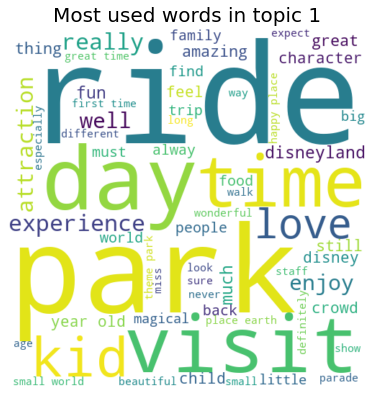

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")


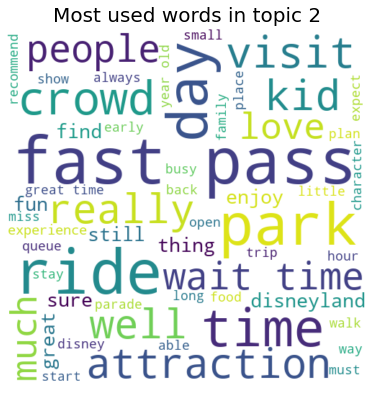

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

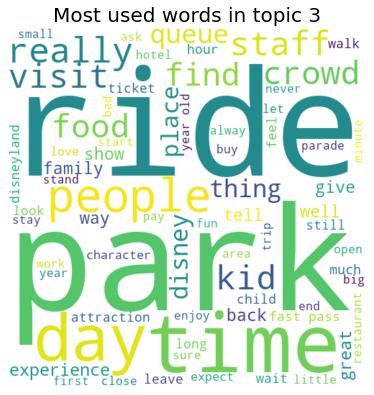

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

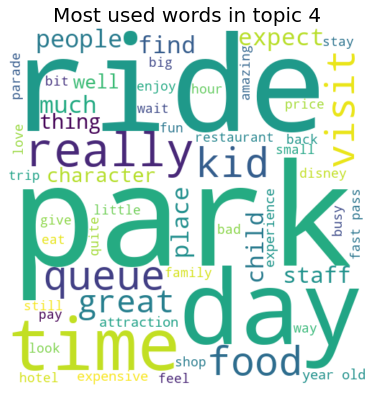

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")